In [1]:
# t=np.linspace(0.01,6,100)

In [2]:
# x=t

On choisit une fonction de t: $$y(t)=0.3[2.1+\sin(t)+\sin(2t)]$$
on calcule sa dérivée première et seconde

Le rayon de courbure au point $P$ est donné par 
$$R=\frac{(1+y'^2)^{3/2}}{y''}$$

In [4]:
# R=(1+yp**2)**(3/2)/(ys)

In [1]:
# p = figure(plot_height=360, plot_width=792, y_range=(-1,2.2), x_range=(0,6))
# l=p.line(x,y)   
# show(p)

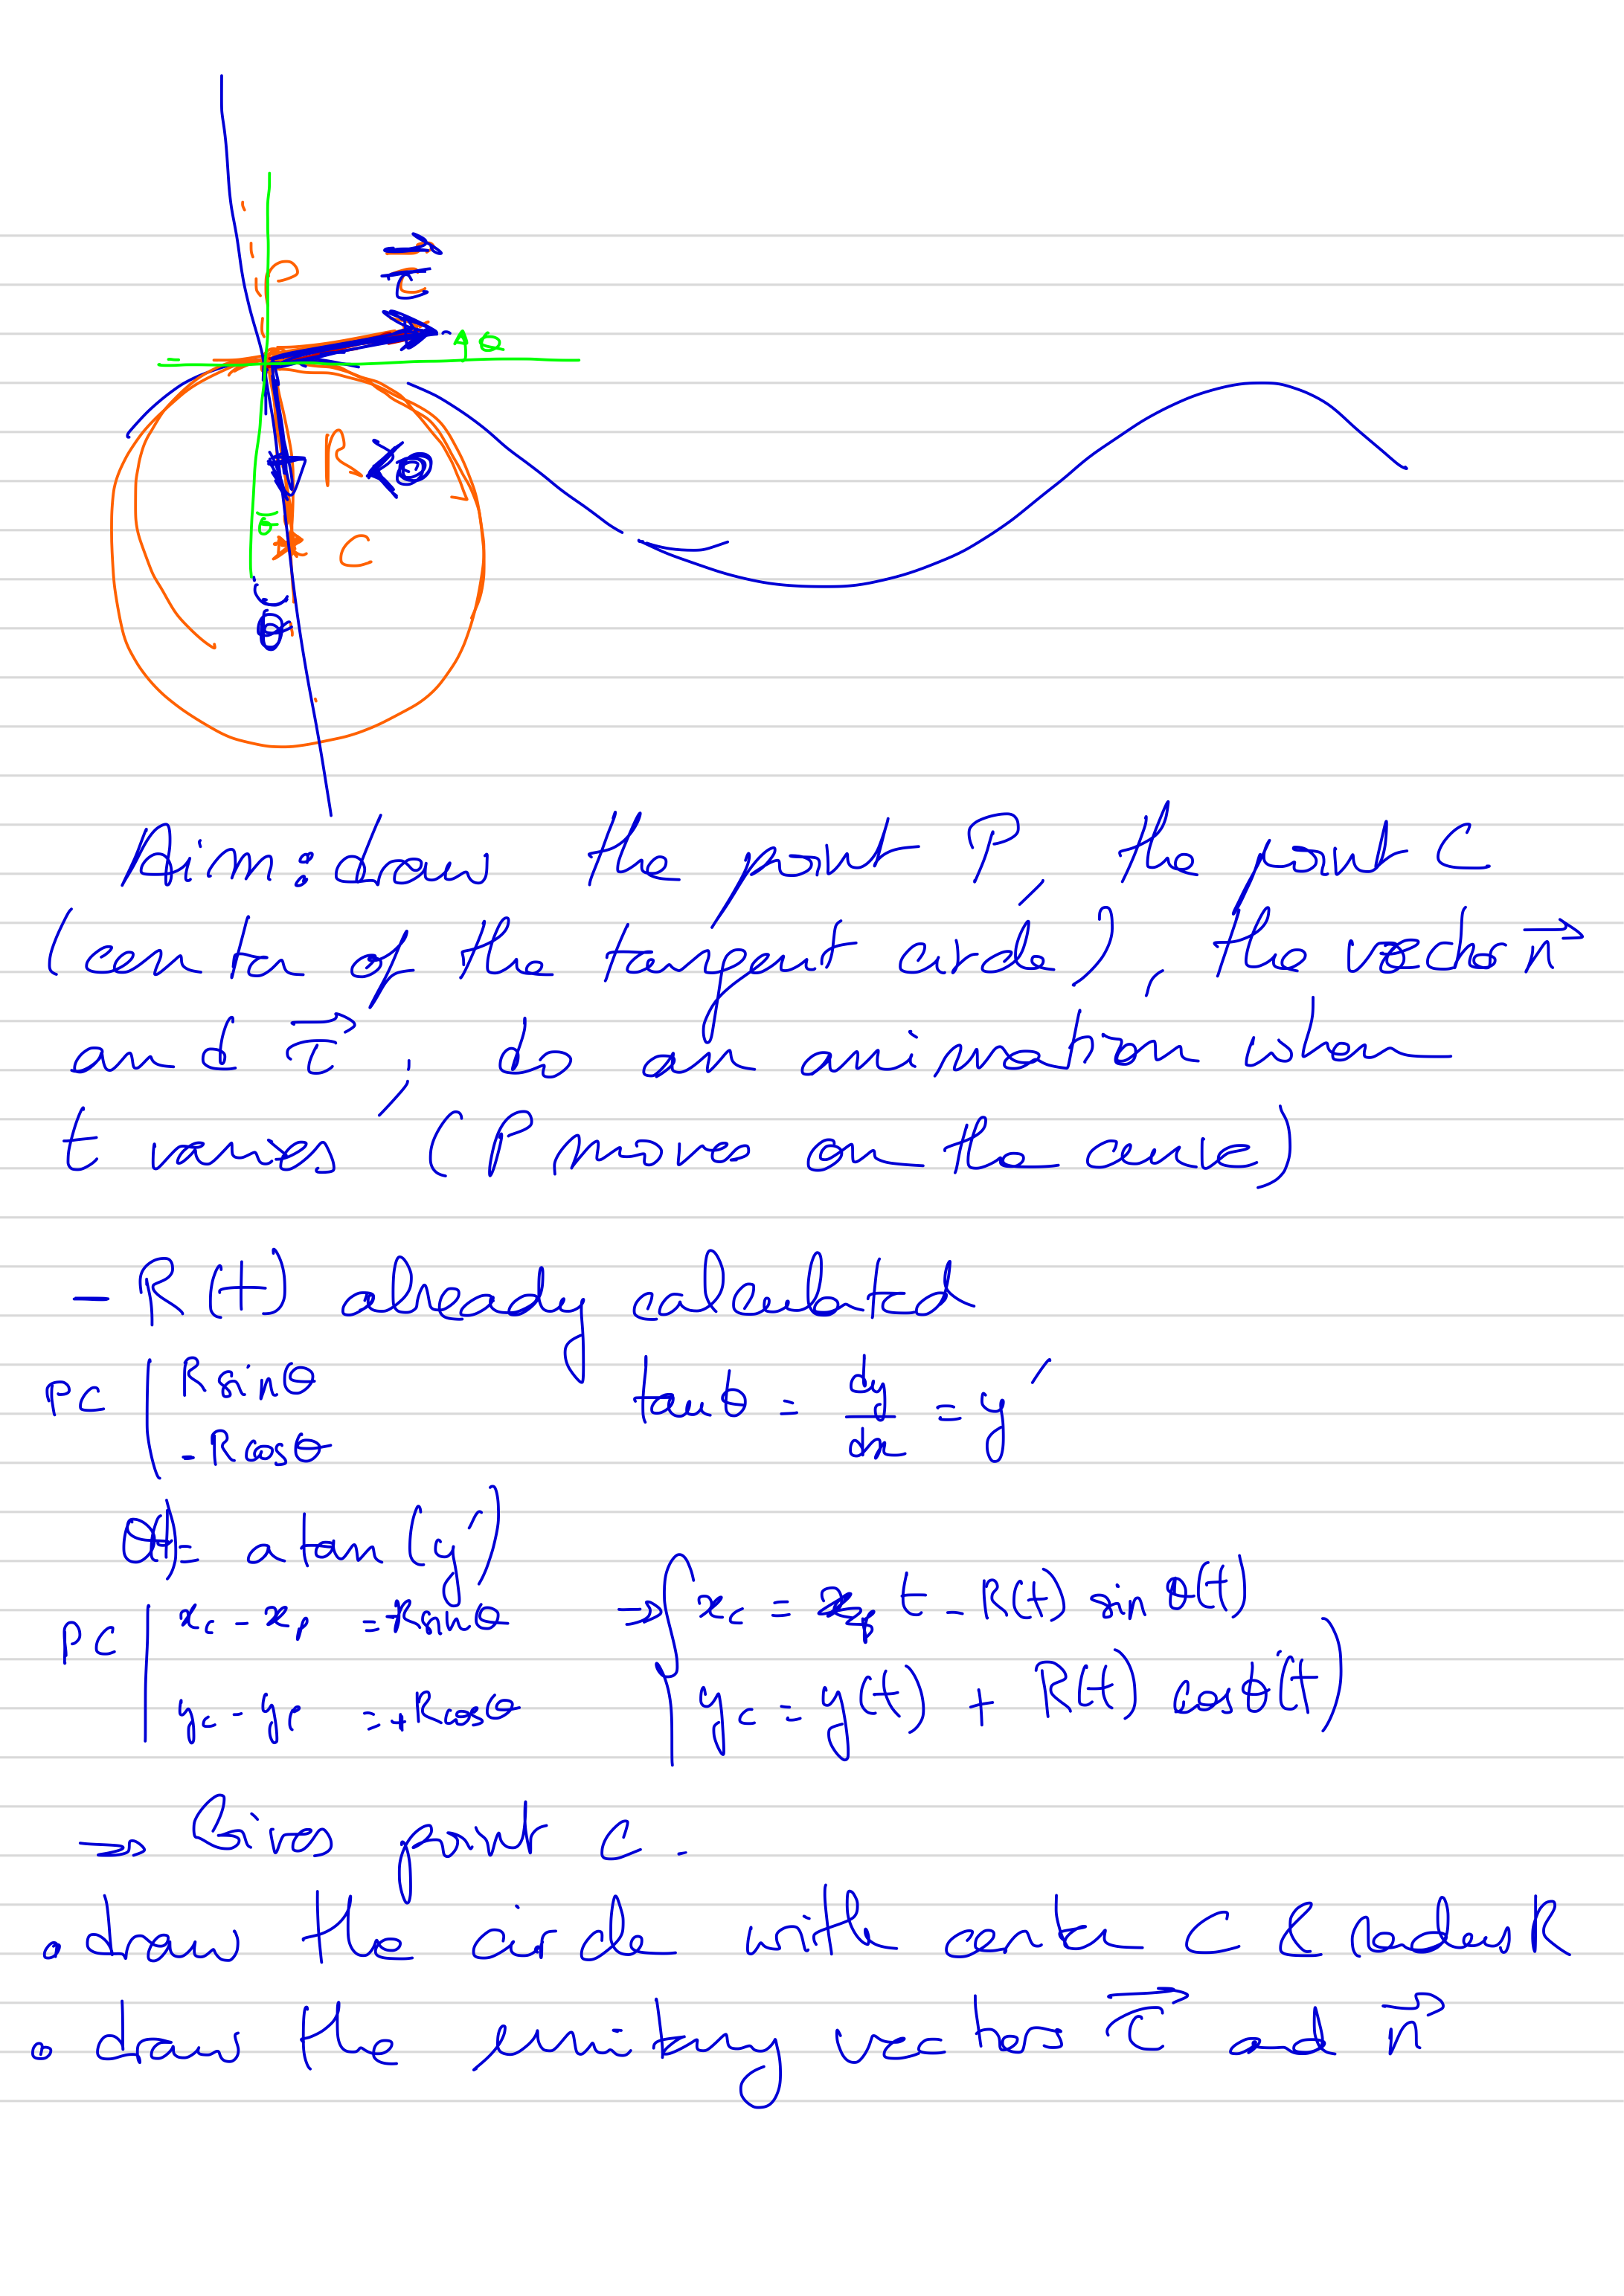

In [2]:
from IPython.display import Image
Image("fresnet.png")

In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.integrate import quadrature
from scipy.misc import derivative

import warnings
warnings.filterwarnings('ignore')

from bokeh.io import output_notebook, push_notebook
from bokeh.models import ColumnDataSource, Arrow, NormalHead
from bokeh.models.markers import Cross
from bokeh.plotting import figure, show
import time

output_notebook()

Loading BokehJS ...

In [22]:
# the curve function
def f(x):
    """
    you can select any of the functions below or
    write down a function yourself!
    
    Comment or uncomment the functions for selection using #
    """
    
#     return np.sin(x)  # a simple sinus
#     return -0.2*(x/2.)**3+2.7*(x/2.)**2-6.9*(x/2.)-5.2 # a degree-3 polynomial
#     return (0.1*x**3+2.7*x**2-10*x-5.2)/(x**2+1.)  # devision of two polynomials
#     return 0.3*(np.sin(x)+2.1+np.sin(2*x)) # a triangular function
    return np.sin(x)+np.cos(x*2)+x # combination of a triangular function and a linear polynomial
    

In [23]:
# it's first derivative: computed automatically
def df(x):
    return derivative(f, x, dx=1e-5, order=5)

# it's second derivative: computed automatically
def ddf(x):
    return derivative(f, x, n=2, dx=1e-5, order=5)

In [24]:
# volocity of the commuter on the curve
V = 2.
# the length of the vectors
L = 1.

def theta(x):
    """
    computes the slope angle
    """
    try:
        return np.arctan(df(x))
    except:
        return np.pi/2
    
def theta_dot(x):
    """
    computes the rate of change of slop's angle
    """
    th = theta(x)
    return ddf(x)*V*np.cos(th)**3
   
def rho(x):
    """
    computes the curvature radius
    """
    if abs(theta_dot(x))>1e-16:
        return V/theta_dot(x)
    else:
        return 10

def new_positions(x):
    """
    computes y,  theta, r and the center of the circle
    """
    x = x.astype(np.float64)
    y = f(x)
    th = theta(x)
    r = rho(x)
    return ( x-r*np.sin(th), y+r*np.cos(th) ) ,r, th, y
   
def compute_position(x, t):
    """
    computes the position of the commuter on the cureve 
    at time t by integration.
    """
    func = lambda x: V/np.sqrt(1+df(x)**2)
    return quadrature(func,0, t,tol=1e-6,maxiter=50)[0]

In [25]:
# plot the curve
X = np.arange(0,20,.2)
Y = f(X)

# time array
dt =0.05
times = np.arange(0,10, dt)

# setting up the sources
t = 0
x = X[0]
center,r, th, y = new_positions(x)

# this source contains the postions of commuter and circle's center
source = ColumnDataSource(data=dict(x=[x], y=[y], radius = [np.abs(r)], \
                                    center_x=[center[0]], center_y=[center[1]]))

# this source contains the vectors' starting and end points
vector_src = ColumnDataSource(data={'begin_x': [x], 'begin_y': [y],\
                                     'tan_end_x': [x+L*np.cos(th)], 'tan_end_y': [y+L*np.sin(th)],\
                                     'rad_end_x': [center[0]], 'rad_end_y': [center[1]]})

# the figure limits: figure must be isometric
dY = Y.max()-Y.min()
dX = X.max()-X.min()
D = 1.4*dX if dX>dY else dY*1.4
x_start = np.round((X.max()+ X.min())/2.,2) - 0.5*D
x_end = np.round((X.max()+ X.min())/2.,2) + 0.5*D
y_start = np.round((Y.max()+ Y.min())/2.,2) - 0.5*D
y_end = np.round((Y.max()+ Y.min())/2.,2)+ 0.5*D

# setting up the figure
plot = figure( title ='Time: '+str(t), match_aspect=True, x_range=(x_start,x_end), y_range=(y_start,y_end), min_border=100)

plot.line(X, Y, line_width=3, line_alpha=0.5,)
point = plot.circle('x','y',  source=source, size=4)
circle = plot.circle('center_x','center_y', radius = 'radius',  source=source, fill_color='green', fill_alpha=0.3 , color ='green', radius_dimension='min')
glyph = Cross(x="center_x", y="center_y", line_color="red", fill_color=None, line_width=2, size=5)
plot.add_glyph(source, glyph)


arrow_setting = NormalHead(line_color="gray", line_width=3, size=6, fill_color='gray', fill_alpha=1)
rad = Arrow(x_start='begin_x', y_start='begin_y', x_end='rad_end_x', y_end='rad_end_y', end=arrow_setting, source=vector_src)
tan = Arrow(x_start='begin_x', y_start='begin_y', x_end='tan_end_x', y_end='tan_end_y', end=arrow_setting, source=vector_src)
plot.add_layout(rad)
plot.add_layout(tan)


handle=show(plot, notebook_handle=True);

# starting of the animation
while t<=times[-1]:
    
    x = point.data_source.data['x']
    y = point.data_source.data['y']
    
    new_x = compute_position(x, t)
    circle_data, new_r, new_th, new_y = new_positions(new_x)
    t += dt 
    
    point.data_source.data['x'] = [new_x]
    point.data_source.data['y'] = [new_y]
    circle.data_source.data['center_x'] = [circle_data[0]]
    circle.data_source.data['center_y'] = [circle_data[1]]
    circle.data_source.data['radius'] = [np.abs(new_r)]# [np.linalg.norm(np.array([circle_data[0]-new_x, circle_data[1]-new_y]))]
    circle.data_source.data['radius_dimension'] = ['x'] if new_y>new_x else ['y']
    
#     [np.abs(new_r)]
  
    new_vec_source = {'begin_x': [new_x], 'begin_y': [new_y],\
                     'tan_end_x': [new_x+L*np.cos(new_th)], 'tan_end_y': [new_y+L*np.sin(new_th)],\
                     'rad_end_x': [circle_data[0]], 'rad_end_y': [circle_data[1]]}
    
    tan.source = ColumnDataSource(data=new_vec_source)
    rad.source = ColumnDataSource(data=new_vec_source)
    
    plot.title.text = 'Time: {0:.2f}'.format(t)
    if t==times[-1]:
        t=0
        x=0
    
    # push updates to the plot continuously using the handle (intererrupt the notebook kernel to stop)
    push_notebook(handle=handle)
    time.sleep(0.01)